In [17]:
pip install --upgrade pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\andre\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [4]:
# Carregando os dados
df_ab_test = pd.read_csv("ab_test_ref.csv")
df_consumer = pd.read_csv("consumer.csv")
df_restaurant = pd.read_csv('restaurant.csv')


In [5]:
df_order = pd.concat(chunk for chunk in pd.read_json('order.json', lines=True, chunksize=10000))

In [ ]:
# Validação tamanho do df
len(df_order)

3670826

In [6]:
# Garantir que 'customer_id' está no mesmo formato
df_order['customer_id'] = df_order['customer_id'].astype(str)
df_ab_test['customer_id'] = df_ab_test['customer_id'].astype(str)
df_consumer['customer_id'] = df_consumer['customer_id'].astype(str) 

In [7]:
# 1. Garanta que os tipos são consistentes
df_order['customer_id'] = df_order['customer_id'].astype('string')
df_ab_test['customer_id'] = df_ab_test['customer_id'].astype('string')

In [9]:
# 2. Reduza a memória usando categorias (se apropriado)
if df_order['customer_id'].nunique()/len(df_order) < 0.5:  # Se muitos valores repetidos
    df_order['customer_id'] = df_order['customer_id'].astype('category')
    df_ab_test['customer_id'] = df_ab_test['customer_id'].astype('category')

In [10]:
# 3. Merge com parâmetros otimizados
df_merged = pd.merge(
    df_ab_test,
    df_order,
    on='customer_id',
    how='left',
    sort=False,  # Não ordenar novamente
    copy=False,  # Evitar cópias desnecessárias
    indicator=False  # Desligar verificação de merge
)

In [12]:
# Ver total de clientes no grupo (com ou sem pedidos)
clientes_no_grupo = df_ab_test.groupby('is_target')['customer_id'].nunique()
clientes_no_grupo

is_target
control    360542
target     445925
Name: customer_id, dtype: int64

In [13]:
# Ver total de clientes no grupo (com ou sem pedidos)
clientes_no_grupo = df_ab_test.groupby('is_target')['customer_id'].nunique()


In [16]:
# E os que têm pelo menos um pedido
clientes_com_pedido = df_merged[~df_merged['order_id'].isna()].groupby('is_target')['customer_id'].nunique()


In [14]:
# Após o merge, verificar quantos clientes não tem pedido 
clientes_sem_pedido = df_merged[df_merged['order_id'].isna()].groupby('is_target')['customer_id'].nunique()


In [17]:
# Comparar
df_check = pd.DataFrame({
    'Clientes no grupo': clientes_no_grupo,
    'Clientes com pedido': clientes_com_pedido,
    'Clientes sem pedido': clientes_sem_pedido
}).fillna(0).astype(int)

display(df_check)

,Clientes no grupo,Clientes com pedido,Clientes sem pedido
is_target,,,
control,360542,360542,0
target,445925,445925,0


In [18]:
# Total de clientes únicos na base de pedidos
clientes_com_pedido_total = df_order['customer_id'].nunique()

In [19]:
# Total de clientes no experimento
clientes_experimento = df_ab_test['customer_id'].nunique()

In [20]:
# Quantos clientes da base de pedidos estão no experimento?
clientes_com_pedido_no_experimento = df_order[df_order['customer_id'].isin(df_ab_test['customer_id'])]['customer_id'].nunique()

print(f"Clientes com pedido (total): {clientes_com_pedido_total}")
print(f"Clientes no experimento: {clientes_experimento}")
print(f"Clientes com pedido que estão no experimento: {clientes_com_pedido_no_experimento}")

Clientes com pedido (total): 806467
Clientes no experimento: 806467
Clientes com pedido que estão no experimento: 806467


In [21]:
# Verificar se todos os customer_id de df_orders estão no df_ab_test
todos_os_clientes_estao_no_ab_test = df_order['customer_id'].isin(df_ab_test['customer_id']).all()

print("Todos os pedidos são de clientes do ab_test?" , todos_os_clientes_estao_no_ab_test)


Todos os pedidos são de clientes do ab_test? True


In [22]:
# Filtrar os pedidos de clientes que não estão no ab_test
pedidos_fora_do_ab_test = df_order[~df_order['customer_id'].isin(df_ab_test['customer_id'])]

print(f"Total de pedidos fora do ab_test: {len(pedidos_fora_do_ab_test)}")
pedidos_fora_do_ab_test.head()


Total de pedidos fora do ab_test: 0


,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date


In [20]:
# Garantir consistência nos valores de is_target
df_ab_test['Grupo'] = df_ab_test['is_target'].str.capitalize()

In [23]:
# Agrupamento
resumo_geral = df_merged.groupby('is_target').agg(
    Clientes_no_grupo=('customer_id', 'nunique'),
    Total_de_pedidos=('order_total_amount', 'count'),
    Receita_total=('order_total_amount', 'sum')
).reset_index()

In [24]:
# Cálculos adicionais
resumo_geral['Pedidos_por_cliente'] = resumo_geral['Total_de_pedidos'] / resumo_geral['Clientes_no_grupo']
resumo_geral['Ticket_medio'] = resumo_geral['Receita_total'] / resumo_geral['Total_de_pedidos']
resumo_geral['Receita_por_cliente'] = resumo_geral['Receita_total'] / resumo_geral['Clientes_no_grupo']


In [25]:
# Formatar valores financeiros
resumo_geral[['Receita_total', 'Ticket_medio', 'Receita_por_cliente']] = resumo_geral[
    ['Receita_total', 'Ticket_medio', 'Receita_por_cliente']
].applymap(lambda x: round(x, 2))

resumo_geral

C:\Users\andre\AppData\Local\Temp\ipykernel_11612\3389216971.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: round(x, 2))


,is_target,Clientes_no_grupo,Total_de_pedidos,Receita_total,Pedidos_por_cliente,Ticket_medio,Receita_por_cliente
0,control,360542,1525576,7.307187e+07,4.231341,47.9,202.67
1,target,445925,2145250,1.027609e+08,4.810787,47.9,230.44


C:\Users\andre\AppData\Local\Temp\ipykernel_31168\2761129540.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_geral, x='is_target', y='Total_de_pedidos', ax=axs[0, 0], palette='Blues_d')
C:\Users\andre\AppData\Local\Temp\ipykernel_31168\2761129540.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_geral, x='is_target', y='Receita_total', ax=axs[0, 1], palette='Greens_d')
C:\Users\andre\AppData\Local\Temp\ipykernel_31168\2761129540.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_geral, x='is_targ

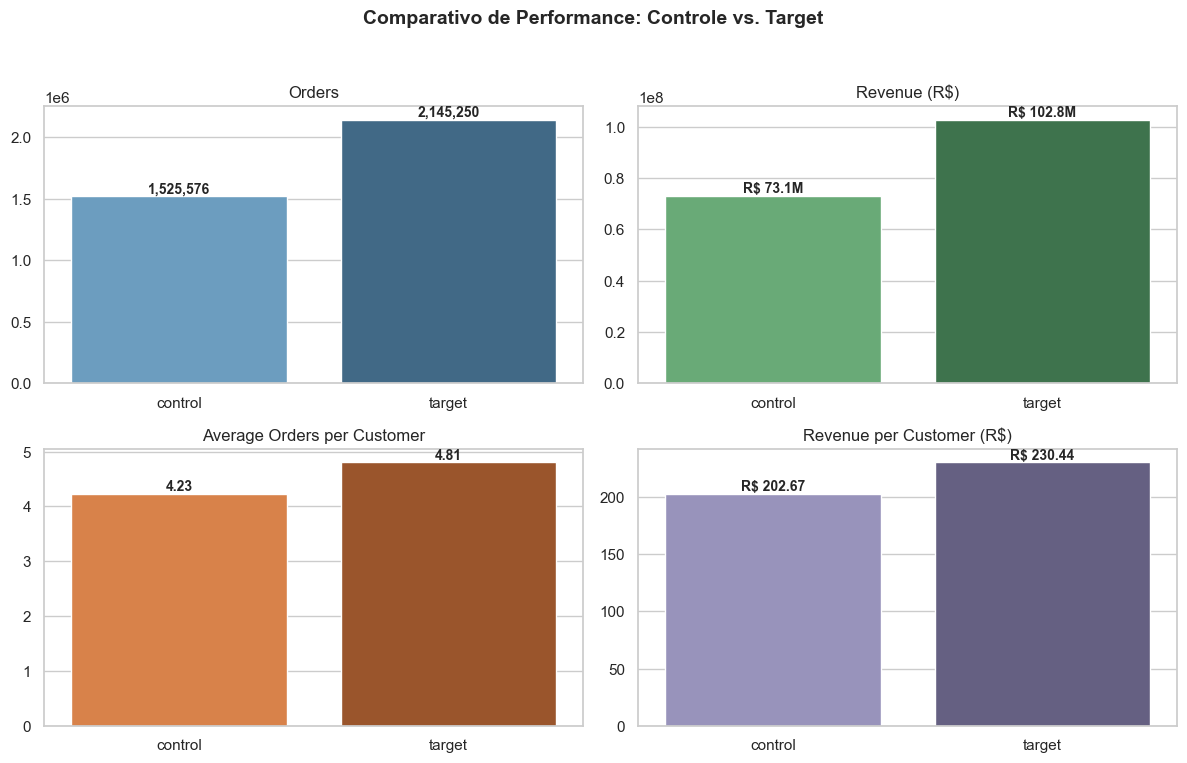

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função auxiliar para formatar milhões e milhares
def format_monetary(value):
    if value >= 1_000_000:
        return f'R$ {value/1_000_000:.1f}M'
    elif value >= 1_000:
        return f'R$ {value/1_000:.1f}K'
    else:
        return f'R$ {value:.2f}'

def add_labels_custom(ax, format_func):
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(format_func(value),
                    (p.get_x() + p.get_width() / 2, value),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Estilo
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 11})

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparativo de Performance: Controle vs. Target', fontsize=14, fontweight='bold')

# Gráfico 1: Total de Pedidos
sns.barplot(data=resumo_geral, x='is_target', y='Total_de_pedidos', ax=axs[0, 0], palette='Blues_d')
axs[0, 0].set_title('Orders')
axs[0, 0].set_ylabel('')
axs[0, 0].set_xlabel('')
add_labels_custom(axs[0, 0], lambda x: f'{x:,.0f}')

# Gráfico 2: Receita Total (com M)
sns.barplot(data=resumo_geral, x='is_target', y='Receita_total', ax=axs[0, 1], palette='Greens_d')
axs[0, 1].set_title('Revenue (R$)')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('')
add_labels_custom(axs[0, 1], format_monetary)

# Gráfico 3: Pedidos por Cliente
sns.barplot(data=resumo_geral, x='is_target', y='Pedidos_por_cliente', ax=axs[1, 0], palette='Oranges_d')
axs[1, 0].set_title('Average Orders per Customer')
axs[1, 0].set_ylabel('')
axs[1, 0].set_xlabel('')
add_labels_custom(axs[1, 0], lambda x: f'{x:.2f}')

# Gráfico 4: Receita por Cliente
sns.barplot(data=resumo_geral, x='is_target', y='Receita_por_cliente', ax=axs[1, 1], palette='Purples_d')
axs[1, 1].set_title('Revenue per Customer (R$)')
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('')
add_labels_custom(axs[1, 1], lambda x: f'R$ {x:.2f}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [50]:
resumo_geral

,is_target,Clientes_no_grupo,Total_de_pedidos,Receita_total,Pedidos_por_cliente,Ticket_medio,Receita_por_cliente
0,control,360542,1525576,7.307187e+07,4.231341,47.9,202.67
1,target,445924,2145250,1.027609e+08,4.810797,47.9,230.44


In [55]:
# Receita incremental

receita_target = resumo_geral.loc[resumo_geral['is_target'] == 'target', 'Receita_total'].values[0]
receita_control = resumo_geral.loc[resumo_geral['is_target'] == 'control', 'Receita_total'].values[0]
receita_incremental = receita_target - receita_control




In [56]:
receita_incremental

np.float64(29689022.090000004)

In [ ]:
pedidos_target = resumo_geral.loc[resumo_geral['is_target'] == 'target', 'Total_de_pedidos'].values[0]
valor_cupom = 10  # premissa
custo_total_campanha = pedidos_target * valor_cupom



In [59]:
custo_total_campanha

np.int64(21452500)

In [60]:
# Margem de contrubuição incremental    
margem_bruta = 0.3  # pode ajustar com benchmark interno
margem_incremental = receita_incremental * margem_bruta


In [61]:
margem_incremental

np.float64(8906706.627)

In [62]:
# Lucro/prejuízo líquido da campanha
lucro_liquido = margem_incremental - custo_total_campanha
lucro_liquido

np.float64(-12545793.373)

In [64]:
roi = lucro_liquido / custo_total_campanha
roi

np.float64(-0.5848173114089267)

In [16]:
len(df_consumer)

806156

In [ ]:
# customer_id como string em todos os dfs
df_order['customer_id'] = df_order['customer_id'].astype(str)
df_ab_test['customer_id'] = df_ab_test['customer_id'].astype(str)
df_consumer['customer_id'] = df_consumer['customer_id'].astype(str)

# Datas como datetime
df_order['order_created_at'] = pd.to_datetime(df_order['order_created_at'])
df_consumer['created_at'] = pd.to_datetime(df_consumer['created_at'])

In [8]:
# Merge das bases
df = df_order.merge(df_ab_test, on='customer_id', how='left')
df = df.merge(df_consumer[['customer_id', 'created_at']], on='customer_id', how='left')


In [10]:
df.head(10)

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date,is_target,created_at
0,80532101763,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,GUSTAVO,FRANCA,BR,JARDIM ESPRAIADO,6736655,-47.39,-20.55,SP,...,-20.55,America/Sao_Paulo,2019-01-17 22:50:06+00:00,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,False,46.0,ANDROID,NaN,control,2018-04-05 23:45:51.591000+00:00
1,43352103961,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,MICHELLE,SANTOS,BR,CAMPO GRANDE,8759216,-46.34,-23.96,SP,...,-23.96,America/Sao_Paulo,2019-01-17 17:51:26+00:00,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,False,104.5,ANDROID,NaN,control,2018-02-04 00:07:47.551000+00:00
2,38650991217,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,VICTOR,GUARULHOS,BR,JARDIM ROSSI,8765930,-46.53,-23.44,SP,...,-23.44,America/Sao_Paulo,2019-01-17 22:53:47+00:00,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,False,35.0,IOS,NaN,control,2018-03-03 23:59:10.670000+00:00
3,63579726866,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,ANNIE,SAO PAULO,BR,PARQUE SAO JORGE,7834087,-46.57,-23.53,SP,...,-23.53,America/Sao_Paulo,2019-01-17 23:56:53+00:00,b4df94142d21354611247da9ca94f870c09b93989b531a...,False,40.8,IOS,NaN,control,2018-01-05 22:17:42.554000+00:00
4,90617788806,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,DANIEL,VITORIA,BR,JARDIM CAMBURI,7211683,-40.27,-20.25,ES,...,-20.25,America/Sao_Paulo,2019-01-17 23:40:53+00:00,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,False,48.5,ANDROID,NaN,target,2018-04-06 00:41:08.195000+00:00
5,49736666572,ad7ddcda2f57003170b8430f2b157c61fb63297bb8622e...,ANDRE,SAO PAULO,BR,JARDIM PAULISTA,1989863,-46.66,-23.57,SP,...,-23.57,America/Sao_Paulo,2019-01-17 23:54:27+00:00,84a9eff359a75fcd34066186d2cd5ec128ebbed47a639c...,False,84.0,IOS,NaN,target,2018-01-04 21:57:44.504000+00:00
6,75685211474,f8946264bb2f7344b271ab452db2d1be7f31ec18d0a890...,PRISCILLA,RIO DE JANEIRO,BR,MADUREIRA,4021471,-43.33,-22.86,RJ,...,-22.86,America/Sao_Paulo,2019-01-17 21:47:53+00:00,8ed9e75f134692b4d3421e85de115343b7bfa5df98fc94...,False,16.0,ANDROID,NaN,target,2018-01-02 20:59:53.463000+00:00
7,23526017552,77d523d52fd20598b8b996e357046dbd7f6cd7fd47b25e...,BRUNO,SAO PAULO,BR,PLANALTO PAULISTA,2837671,-46.64,-23.62,SP,...,-23.62,America/Sao_Paulo,2019-01-17 23:25:59+00:00,94e31a4d37f49bda0fbf6d68bd0c21ca06827e50cc7437...,False,43.9,IOS,NaN,target,2018-01-12 23:31:24.543000+00:00
8,6823673386,4099e6f87d7910fd88f96a6c853227437ee89b68aae52c...,EDUARDO,FORTALEZA,BR,MEIRELES,2972297,-38.50,-3.73,CE,...,-3.73,America/Fortaleza,2019-01-17 22:28:09+00:00,d928f06312a10ae20ddbad7cb24bf004d3210b29047f38...,False,35.9,IOS,NaN,control,2018-01-06 12:32:03.730000+00:00
9,79719037778,39e02a93ff21345e7ab41484ad4e125b906df3408be659...,Amanda,RIO DE JANEIRO,BR,QUINTINO BOCAIUVA,2938122,-43.32,-22.89,RJ,...,-22.89,America/Sao_Paulo,2019-01-17 22:49:28+00:00,2c299d7071fe54264662e3076b5ec853f1fadd7cbaebd2...,False,46.0,ANDROID,NaN,target,2018-01-20 18:35:04.793000+00:00


In [11]:
# Cruzar df_ab_test para trazer is_target para pedidos
df_order = df_order.merge(df_ab_test[['customer_id', 'is_target']], on='customer_id', how='left')


In [12]:
# Pegar do df_order a data do primeiro pedido por cliente
df_first_order = df_order.groupby('customer_id')['order_created_at'].min().reset_index().rename(columns={'order_created_at':'first_order_date'})


In [13]:
# Cruzar com o created_at do usuário de df_consumer
df_recencia = df_first_order.merge(df_consumer[['customer_id', 'created_at']], on='customer_id', how='left')


In [14]:
# Calcular a recência: diferença em dias entre primeiro pedido e data de criação do usuário
df_recencia['recencia_dias'] = (df_recencia['first_order_date'] - df_recencia['created_at']).dt.days


In [15]:
# faixas recencia
def categoriza_recencia(dias):
    if pd.isna(dias):
        return 'Desconhecido'
    elif dias <= 15:
        return 'Novo'
    elif 16 <= dias <= 30:
        return 'Médio'
    else:
        return 'Antigo'

df_recencia['segmento_recencia'] = df_recencia['recencia_dias'].apply(categoriza_recencia)


In [102]:
# Valicação recencia
top_10_recencia = df_recencia.sort_values(by='recencia_dias', ascending=True).head(10)
top_10_recencia['first_order_date'] = pd.to_datetime(top_10_recencia['first_order_date']).dt.date
top_10_recencia['created_at'] = pd.to_datetime(top_10_recencia['created_at']).dt.date
top_10_recencia['recencia_dias'] = top_10_recencia['recencia_dias'].astype(int)
top_10_recencia

,customer_id,first_order_date,created_at,recencia_dias,segmento_recencia
717283,e3b8b8492ffc5d86acc518b526c2a3af858b8bda023ae9...,2018-12-03,2018-04-06,240,Antigo
196713,3e7b7b9ff66b8572c972d5a7b8bb689261c024d59ddf63...,2018-12-03,2018-04-06,240,Antigo
151475,301ba064d29051d7316518ad7ec826254b1ca457dde29b...,2018-12-03,2018-04-06,240,Antigo
736774,e9efeb8c9a5bdbe0ccf15f7b4ae1a6b3f5ac11c150bbd0...,2018-12-03,2018-04-06,240,Antigo
271133,56071351314ae6ceee991de3df65bce5d11caa8ec7a250...,2018-12-03,2018-04-06,240,Antigo
240829,4c86c70613993ff8c866a71635058befa4de4e6d744db5...,2018-12-03,2018-04-06,240,Antigo
64663,14707731f005f0fd6bebd363190bc0e4e0b21b09e2ad10...,2018-12-03,2018-04-06,240,Antigo
388422,7b34f8daf6bd44b402218ed49ff2a5efe1882830ab91b5...,2018-12-03,2018-04-06,240,Antigo
151437,3017b945c57997f983992ac5b1a28385fba369ceb07d48...,2018-12-03,2018-04-06,240,Antigo
600130,be80e116ea65cef08f5cf8aca5760f02bc8ae2ff122e42...,2018-12-03,2018-04-06,240,Antigo


In [ ]:
top_10_recencia[['created_at']].sort_values(by='created_at', ascending=False).head(10)


,created_at
196713,2018-04-06 04:14:52.995000+00:00
151475,2018-04-06 04:14:52.995000+00:00
736774,2018-04-06 04:14:52.995000+00:00
240829,2018-04-06 04:14:52.995000+00:00
388422,2018-04-06 04:14:52.995000+00:00
151437,2018-04-06 04:14:52.995000+00:00
717283,2018-04-06 04:08:14.810000+00:00
600130,2018-04-06 03:45:05.366000+00:00
64663,2018-04-06 03:42:03.665000+00:00
271133,2018-04-06 01:32:13.045000+00:00


In [31]:
len(df_recencia)

806467

In [32]:
len(df_ab_test)

806467

In [33]:
len(df_consumer)

806156

In [21]:
# Info de pedidos para cada cliente
df_metrics = df_order.groupby('customer_id').agg(
    num_pedidos=('order_id', 'count'),
    ticket_medio=('order_total_amount', 'mean'),
    valor_total=('order_total_amount', 'sum'),
    is_target=('is_target', 'first')
).reset_index()

In [22]:
# Fequencia e ticket médio

def categoriza_frequencia(n):
    if n == 1:
        return '1 pedido'
    elif n == 2:
        return '2 pedidos'
    else:
        return '3+ pedidos'

def categoriza_ticket(valor):
    if valor < 30:
        return 'Baixo'
    elif 30 <= valor <= 70:
        return 'Médio'
    else:
        return 'Alto'

df_metrics['segmento_frequencia'] = df_metrics['num_pedidos'].apply(categoriza_frequencia)
df_metrics['segmento_ticket'] = df_metrics['ticket_medio'].apply(categoriza_ticket)


In [23]:
df_final = df_metrics.merge(df_recencia[['customer_id', 'segmento_recencia']], on='customer_id', how='left')


In [24]:
df_final.head(10)

,customer_id,num_pedidos,ticket_medio,valor_total,is_target,segmento_frequencia,segmento_ticket,segmento_recencia
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,10,37.300000,373.00,control,3+ pedidos,Médio,Antigo
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,5,58.760000,293.80,target,3+ pedidos,Médio,Antigo
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,4,34.325000,137.30,target,3+ pedidos,Médio,Antigo
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,2,88.800000,177.60,control,2 pedidos,Alto,Antigo
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,5,106.620000,533.10,target,3+ pedidos,Alto,Antigo
5,0000bb10fb47a1d6b2d73754ef383950ef536c77d07212...,4,94.095000,376.38,control,3+ pedidos,Alto,Antigo
6,0000c21984ae00cefb5d4931bfa49483dde546413c9b40...,34,45.291765,1539.92,control,3+ pedidos,Médio,Antigo
7,0000f399c324f0463577b43bae1fd817f31e6fe768405a...,1,38.000000,38.00,target,1 pedido,Médio,Antigo
8,0001004b6873a53fef60d11f4d2e4435ea27bed7e5fc38...,1,30.900000,30.90,target,1 pedido,Médio,Antigo
9,00010814ab1e602ccbc9ffe3b64f44973491b2fd6d8ab7...,4,57.000000,228.00,control,3+ pedidos,Médio,Antigo


In [25]:
df_segmentos = df_final.groupby(['is_target', 'segmento_frequencia', 'segmento_ticket', 'segmento_recencia']).agg(
    num_clientes=('customer_id', 'nunique'),
    num_pedidos=('num_pedidos', 'sum'),
    media_ticket=('ticket_medio', 'mean'),
    total_valor=('valor_total', 'sum')
).reset_index()


In [26]:
df_segmentos

,is_target,segmento_frequencia,segmento_ticket,segmento_recencia,num_clientes,num_pedidos,media_ticket,total_valor
0,control,1 pedido,Alto,Antigo,13434,13434,109.842199,1475620.10
1,control,1 pedido,Alto,Desconhecido,5,5,109.860000,549.30
2,control,1 pedido,Baixo,Antigo,26964,26964,21.710080,585390.61
3,control,1 pedido,Baixo,Desconhecido,12,12,21.565833,258.79
4,control,1 pedido,Médio,Antigo,50770,50770,45.745258,2322486.76
5,control,1 pedido,Médio,Desconhecido,16,16,45.798125,732.77
6,control,2 pedidos,Alto,Antigo,16418,32836,108.174265,3552010.17
7,control,2 pedidos,Alto,Desconhecido,5,10,107.776000,1077.76
8,control,2 pedidos,Baixo,Antigo,34147,68294,21.776207,1487184.29
9,control,2 pedidos,Baixo,Desconhecido,14,28,22.933571,642.14


In [139]:
total_pedidos = df_segmentos['num_pedidos'].sum()
print(f"Total de pedidos: {total_pedidos}")

Total de pedidos: 3670826


In [27]:
total_pedidos_target_real = df_segmentos[df_segmentos['is_target'] == 'target']['num_pedidos'].sum()
print(f"Total de pedidos grupo target (verificação): {total_pedidos_target_real:,}")


Total de pedidos grupo target (verificação): 2,145,250


In [28]:
def plot_segment_value(df, segment_column, title):
    # Agrega valor total por segmento e grupo
    df_agg = df.groupby([segment_column, 'is_target'])['total_valor'].sum().reset_index()

    # Ajusta os rótulos do grupo
    df_agg['Grupo'] = df_agg['is_target'].str.capitalize()

    # Cria o gráfico de barras
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_agg, x=segment_column, y='total_valor', hue='Grupo')

    # Adiciona os rótulos no topo das barras, com abreviação (em milhões)
    for p in ax.patches:
        height = p.get_height()
        label = f'{height/1_000_000:.1f}M'  # Converte para milhões com uma casa decimal
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9)

    plt.title(title)
    plt.xlabel(segment_column)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

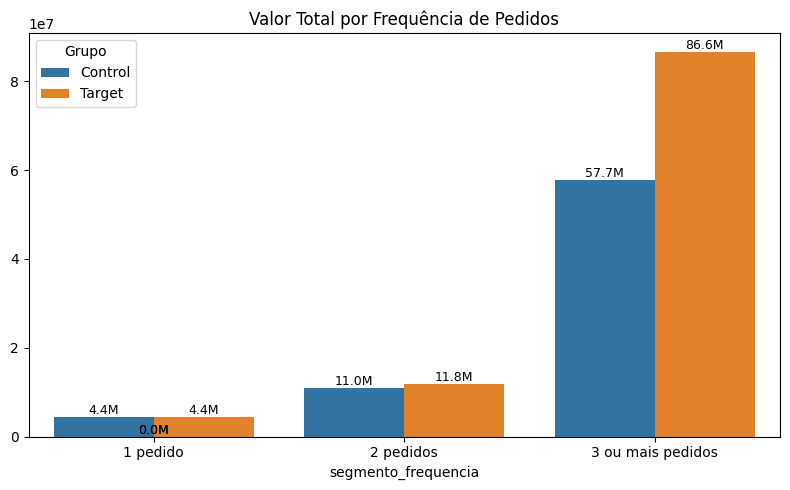

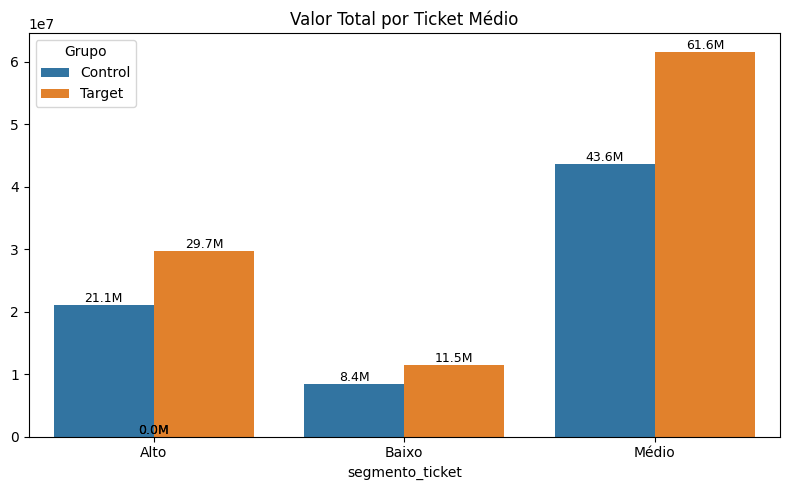

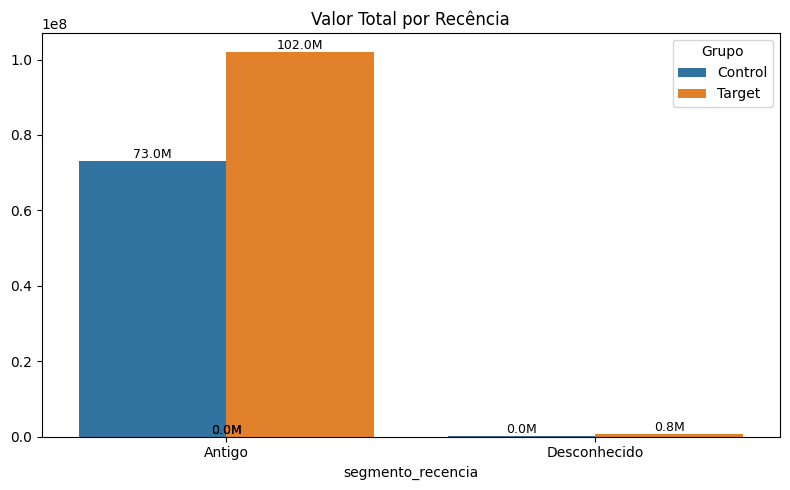

In [142]:
plot_segment_value(df_segmentos, 'segmento_frequencia', 'Valor Total por Frequência de Pedidos')
plot_segment_value(df_segmentos, 'segmento_ticket', 'Valor Total por Ticket Médio')
plot_segment_value(df_segmentos, 'segmento_recencia', 'Valor Total por Recência')

In [ ]:
# ROI

# Define os segmentos que queremos analisar
segmentos_interesse = [
    {'segmento_frequencia': '3+'},  # ROI 1
    {'segmento_ticket': 'Médio'},                 # ROI 2
    {'segmento_ticket': 'Alto'}                   # ROI 3
]



In [51]:
# Cupom fixo e margem bruta
valor_cupom = 10
margem_bruta = 0.30

In [52]:
# Inicializa lista de resultados
resultados_roi = []

In [60]:
resultados_roi

[]

In [62]:
print(df_segmentos['segmento_frequencia'].unique())


['1 pedido' '2 pedidos' '3+ pedidos']


In [ ]:
# Loop pelos segmentos
segmentos_interesse = [
    {'segmento_frequencia': '3+'},
    {'segmento_ticket': 'Médio'},
    {'segmento_ticket': 'Alto'}
]

resultados_roi = []

for condicao in segmentos_interesse:
    for key, valor in condicao.items():

        # CASO ESPECIAL para 'segmento_frequencia' = '3+'
        if key == 'segmento_frequencia' and valor == '3+':
            filtro_target = (df_segmentos['is_target'] == 'target') & (df_segmentos[key] == '3+ pedidos')
            filtro_control = (df_segmentos['is_target'] == 'control') & (df_segmentos[key] == '3+ pedidos')
        else:
            filtro_target = (df_segmentos['is_target'] == 'target') & (df_segmentos[key] == valor)
            filtro_control = (df_segmentos['is_target'] == 'control') & (df_segmentos[key] == valor)

        df_target = df_segmentos[filtro_target]
        df_control = df_segmentos[filtro_control]

        receita_target = df_target['total_valor'].sum()
        receita_control = df_control['total_valor'].sum()
        pedidos_target = df_target['num_pedidos'].sum()
        incremento = receita_target - receita_control
        custo_campanha = pedidos_target * valor_cupom
        margem_incremental = incremento * margem_bruta
        lucro_liquido = margem_incremental - custo_campanha
        roi = lucro_liquido / custo_campanha if custo_campanha > 0 else None

        resultados_roi.append({
            'segmento': f"{key} = {valor}",
            'receita_target': round(receita_target, 2),
            'receita_control': round(receita_control, 2),
            'incremento_receita': round(incremento, 2),
            'pedidos_target': int(pedidos_target),
            'custo_campanha': round(custo_campanha, 2),
            'margem_incremental (30%)': round(margem_incremental, 2),
            'lucro_liquido': round(lucro_liquido, 2),
            'ROI': round(roi, 2) if roi is not None else None
        })


In [64]:
# Converte para DataFrame
df_roi = pd.DataFrame(resultados_roi)

In [65]:
# Exibe a tabela de ROI
df_roi

,segmento,receita_target,receita_control,incremento_receita,pedidos_target,custo_campanha,margem_incremental (30%),lucro_liquido,ROI
0,segmento_frequencia = 3+,86575316.25,57717293.61,28858022.64,1805676,18056760,8657406.79,-9399353.21,-0.52
1,segmento_ticket = Médio,61562709.27,43635775.35,17926933.92,1349253,13492530,5378080.18,-8114449.82,-0.60
2,segmento_ticket = Alto,29685632.16,21070455.30,8615176.86,300619,3006190,2584553.06,-421636.94,-0.14


In [72]:
# Segmentação combinada
df_target_comb = df_segmentos[
    (df_segmentos['is_target'] == 'target') &
    (df_segmentos['segmento_frequencia'] == '3+ pedidos') &
    (df_segmentos['segmento_ticket'].isin(['Médio', 'Alto']))
]

df_control_comb = df_segmentos[
    (df_segmentos['is_target'] == 'control') &
    (df_segmentos['segmento_frequencia'] == '3+ pedidos') &
    (df_segmentos['segmento_ticket'].isin(['Médio', 'Alto']))
]

In [73]:
# Receita
receita_target_comb = df_target_comb['total_valor'].sum()
receita_control_comb = df_control_comb['total_valor'].sum()

In [74]:
# Pedidos
pedidos_target_comb = df_target_comb['num_pedidos'].sum()

In [75]:
# Cálculos financeiros
incremento_receita_comb = receita_target_comb - receita_control_comb
custo_campanha_comb = pedidos_target_comb * valor_cupom
margem_incremental_comb = incremento_receita_comb * margem_bruta
lucro_liquido_comb = margem_incremental_comb - custo_campanha_comb
roi_comb = lucro_liquido_comb / custo_campanha_comb if custo_campanha_comb > 0 else None

In [76]:
# Exibir
print("📊 ROI - Segmentos combinados (Freq ≥ 3 + Ticket Médio ou Alto)")
print(f"Receita target: R$ {receita_target_comb:,.2f}")
print(f"Receita control: R$ {receita_control_comb:,.2f}")
print(f"Incremento de receita: R$ {incremento_receita_comb:,.2f}")
print(f"Total de pedidos target: {pedidos_target_comb:,}")
print(f"Custo da campanha: R$ {custo_campanha_comb:,.2f}")
print(f"Margem incremental (30%): R$ {margem_incremental_comb:,.2f}")
print(f"Lucro líquido: R$ {lucro_liquido_comb:,.2f}")
print(f"ROI: {roi_comb:.2%}")

📊 ROI - Segmentos combinados (Freq ≥ 3 + Ticket Médio ou Alto)
Receita target: R$ 77,241,940.89
Receita control: R$ 51,425,127.21
Incremento de receita: R$ 25,816,813.68
Total de pedidos target: 1,410,109
Custo da campanha: R$ 14,101,090.00
Margem incremental (30%): R$ 7,745,044.10
Lucro líquido: R$ -6,356,045.90
ROI: -45.07%


In [77]:
# Exibir
print("📊 ROI - Segmentos combinados (Freq ≥ 3 + Ticket Médio ou Alto)")
print(f"Receita target: R$ {receita_target_comb:,.2f}")
print(f"Receita control: R$ {receita_control_comb:,.2f}")
print(f"Incremento de receita: R$ {incremento_receita_comb:,.2f}")
print(f"Total de pedidos target: {pedidos_target_comb:,}")
print(f"Custo da campanha: R$ {custo_campanha_comb:,.2f}")
print(f"Margem incremental (30%): R$ {margem_incremental_comb:,.2f}")
print(f"Lucro líquido: R$ {lucro_liquido_comb:,.2f}")
print(f"ROI: {roi_comb:.2%}")

📊 ROI - Segmentos combinados (Freq ≥ 3 + Ticket Médio ou Alto)
Receita target: R$ 77,241,940.89
Receita control: R$ 51,425,127.21
Incremento de receita: R$ 25,816,813.68
Total de pedidos target: 1,410,109
Custo da campanha: R$ 14,101,090.00
Margem incremental (30%): R$ 7,745,044.10
Lucro líquido: R$ -6,356,045.90
ROI: -45.07%


In [78]:
# Listas de valores possíveis
frequencias = df_segmentos['segmento_frequencia'].unique()
tickets = df_segmentos['segmento_ticket'].unique()

resultados_combinacoes = []

In [79]:
# Loop por todas as combinações possíveis de frequência e ticket
for freq in frequencias:
    for ticket in tickets:
        df_target_sub = df_segmentos[
            (df_segmentos['is_target'] == 'target') &
            (df_segmentos['segmento_frequencia'] == freq) &
            (df_segmentos['segmento_ticket'] == ticket)
        ]
        df_control_sub = df_segmentos[
            (df_segmentos['is_target'] == 'control') &
            (df_segmentos['segmento_frequencia'] == freq) &
            (df_segmentos['segmento_ticket'] == ticket)
        ]

        # Receita e pedidos
        receita_target = df_target_sub['total_valor'].sum()
        receita_control = df_control_sub['total_valor'].sum()
        pedidos_target = df_target_sub['num_pedidos'].sum()

        if pedidos_target == 0:
            continue  # pula se não houve pedidos

        # Cálculos
        incremento = receita_target - receita_control
        custo = pedidos_target * valor_cupom
        margem = incremento * margem_bruta
        lucro = margem - custo
        roi = lucro / custo if custo > 0 else None

        resultados_combinacoes.append({
            'segmento_frequencia': freq,
            'segmento_ticket': ticket,
            'receita_target': round(receita_target, 2),
            'receita_control': round(receita_control, 2),
            'incremento_receita': round(incremento, 2),
            'pedidos_target': int(pedidos_target),
            'custo_campanha': round(custo, 2),
            'margem_incremental': round(margem, 2),
            'lucro_liquido': round(lucro, 2),
            'ROI': round(roi, 4)
        })


In [80]:

# Transformar em DataFrame
df_resultados_combinacoes = pd.DataFrame(resultados_combinacoes)

In [93]:
# Ordenar por ROI decrescente para ver os melhores resultados
df_resultados_combinacoes.sort_values(by='ROI', ascending=False, inplace=True)

In [82]:
df_resultados_combinacoes.sort_values(by='ROI', ascending=False).head(10)


,segmento_frequencia,segmento_ticket,receita_target,receita_control,incremento_receita,pedidos_target,custo_campanha,margem_incremental,lucro_liquido,ROI
6,3+ pedidos,Alto,24433727.39,16041197.97,8392529.42,252136,2521360,2517758.83,-3601.17,-0.0014
8,3+ pedidos,Médio,52808213.50,35383929.24,17424284.26,1157973,11579730,5227285.28,-6352444.72,-0.5486
7,3+ pedidos,Baixo,9333375.36,6292166.40,3041208.96,395567,3955670,912362.69,-3043307.31,-0.7694
3,2 pedidos,Alto,3774127.91,3553087.93,221039.98,34952,349520,66311.99,-283208.01,-0.8103
5,2 pedidos,Médio,6429357.25,5928626.58,500730.67,140476,1404760,150219.20,-1254540.80,-0.8931
4,2 pedidos,Baixo,1590983.21,1487826.43,103156.78,72760,727600,30947.03,-696652.97,-0.9575
0,1 pedido,Alto,1477776.86,1476169.40,1607.46,13531,135310,482.24,-134827.76,-0.9964
1,1 pedido,Baixo,588194.97,585649.40,2545.57,27051,270510,763.67,-269746.33,-0.9972
2,1 pedido,Médio,2325138.52,2323219.53,1918.99,50804,508040,575.70,-507464.30,-0.9989


In [83]:
# Novo cenário: Cumpom de R$ 5
# Parâmetros
valor_cupom_reduzido = 5
margem_bruta = 0.30

# Filtra o segmento específico
segmento = df_segmentos[
    (df_segmentos['segmento_frequencia'] == '3+ pedidos') &
    (df_segmentos['segmento_ticket'] == 'Alto')
]

In [84]:
# Divide entre target e controle
df_target = segmento[segmento['is_target'] == 'target']
df_control = segmento[segmento['is_target'] == 'control']


In [85]:
# Receita total
receita_target = df_target['total_valor'].sum()
receita_control = df_control['total_valor'].sum()

In [86]:

# Total de pedidos reais (sem inflar)
pedidos_target = df_target['num_pedidos'].sum()

In [87]:
pedidos_target

np.int64(252136)

In [88]:
# Incremento de receita
incremento = receita_target - receita_control

In [89]:
# Custo da campanha com cupom de R$5
custo_campanha = pedidos_target * valor_cupom_reduzido

In [90]:

# Margem incremental (30%)
margem_incremental = incremento * margem_bruta

In [91]:

# Lucro líquido
lucro_liquido = margem_incremental - custo_campanha

In [92]:
# ROI
roi = lucro_liquido / custo_campanha if custo_campanha > 0 else None

In [93]:
# Exibição
print(f"ROI - Segmento: 3+ pedidos & Ticket Alto com cupom R${valor_cupom_reduzido}")
print(f"Receita target: R$ {receita_target:,.2f}")
print(f"Receita control: R$ {receita_control:,.2f}")
print(f"Incremento de receita: R$ {incremento:,.2f}")
print(f"Total de pedidos target: {pedidos_target:,}")
print(f"Custo da campanha: R$ {custo_campanha:,.2f}")
print(f"Margem incremental (30%): R$ {margem_incremental:,.2f}")
print(f"Lucro líquido: R$ {lucro_liquido:,.2f}")
print(f"ROI: {roi:.2%}")

ROI - Segmento: 3+ pedidos & Ticket Alto com cupom R$5
Receita target: R$ 24,433,727.39
Receita control: R$ 16,041,197.97
Incremento de receita: R$ 8,392,529.42
Total de pedidos target: 252,136
Custo da campanha: R$ 1,260,680.00
Margem incremental (30%): R$ 2,517,758.83
Lucro líquido: R$ 1,257,078.83
ROI: 99.71%


In [94]:
# Todos os segmentos com cupom de R$ 5  

# Parâmetros
valor_cupom = 5
margem_bruta = 0.30

# Listas únicas de segmentos
frequencias = df_segmentos['segmento_frequencia'].unique()
tickets = df_segmentos['segmento_ticket'].unique()

# Lista para armazenar os resultados
resultados_combinacoes = []

# Loop pelas combinações
for freq in frequencias:
    for ticket in tickets:
        df_target_sub = df_segmentos[
            (df_segmentos['is_target'] == 'target') &
            (df_segmentos['segmento_frequencia'] == freq) &
            (df_segmentos['segmento_ticket'] == ticket)
        ]
        df_control_sub = df_segmentos[
            (df_segmentos['is_target'] == 'control') &
            (df_segmentos['segmento_frequencia'] == freq) &
            (df_segmentos['segmento_ticket'] == ticket)
        ]

        # Cálculos de receita e volume de pedidos
        receita_target = df_target_sub['total_valor'].sum()
        receita_control = df_control_sub['total_valor'].sum()
        pedidos_target = df_target_sub['num_pedidos'].sum()

        if pedidos_target == 0:
            continue  # pula segmentos sem pedidos

        incremento = receita_target - receita_control
        custo = pedidos_target * valor_cupom
        margem = incremento * margem_bruta
        lucro = margem - custo
        roi = lucro / custo if custo > 0 else None

        resultados_combinacoes.append({
            'segmento_frequencia': freq,
            'segmento_ticket': ticket,
            'receita_target': round(receita_target, 2),
            'receita_control': round(receita_control, 2),
            'incremento_receita': round(incremento, 2),
            'pedidos_target': int(pedidos_target),
            'custo_campanha': round(custo, 2),
            'margem_incremental': round(margem, 2),
            'lucro_liquido': round(lucro, 2),
            'ROI': round(roi, 4) if roi is not None else None
        })

# Converter para DataFrame e ordenar por ROI
df_resultados = pd.DataFrame(resultados_combinacoes)
df_resultados = df_resultados.sort_values(by="ROI", ascending=False)




In [95]:
df_resultados

,segmento_frequencia,segmento_ticket,receita_target,receita_control,incremento_receita,pedidos_target,custo_campanha,margem_incremental,lucro_liquido,ROI
6,3+ pedidos,Alto,24433727.39,16041197.97,8392529.42,252136,1260680,2517758.83,1257078.83,0.9971
8,3+ pedidos,Médio,52808213.50,35383929.24,17424284.26,1157973,5789865,5227285.28,-562579.72,-0.0972
7,3+ pedidos,Baixo,9333375.36,6292166.40,3041208.96,395567,1977835,912362.69,-1065472.31,-0.5387
3,2 pedidos,Alto,3774127.91,3553087.93,221039.98,34952,174760,66311.99,-108448.01,-0.6206
5,2 pedidos,Médio,6429357.25,5928626.58,500730.67,140476,702380,150219.20,-552160.80,-0.7861
4,2 pedidos,Baixo,1590983.21,1487826.43,103156.78,72760,363800,30947.03,-332852.97,-0.9149
0,1 pedido,Alto,1477776.86,1476169.40,1607.46,13531,67655,482.24,-67172.76,-0.9929
1,1 pedido,Baixo,588194.97,585649.40,2545.57,27051,135255,763.67,-134491.33,-0.9944
2,1 pedido,Médio,2325138.52,2323219.53,1918.99,50804,254020,575.70,-253444.30,-0.9977
